In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\Alex van Tol\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [18]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

#cat_vars = ['Store', 'DayOfWeek']

In [19]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [20]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [21]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


# Asignación de dimensión de embeddings

In [22]:
cat_var_dict = {'Store': 1115, 
                'DayOfWeek': 7, 
                'Year': 5, 
                'Month': 12, 
                'Day': 31, 
                'StateHoliday': 4, 
                'CompetitionMonthsOpen': 30,
                'Promo2Weeks': 1, 
                'StoreType': 2, 
                'Assortment': 3, 
                'PromoInterval': 3,
                'CompetitionOpenSinceYear': 4, 
                'Promo2SinceYear': 4, 'State': 6,
                'Week': 52, 
                'Events': 30, 
                'Promo_fw': 6,
                'Promo_bw': 6,
                'StateHoliday_bool_fw': 3,
                'StateHoliday_bool_bw': 3, 
                'SchoolHoliday_fw': 8,
                'SchoolHoliday_bw': 8}

In [23]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print(v)

Store 1115 1115 [   0    1    2 ... 1112 1113 1114]
Store
DayOfWeek 7 7 [0 1 2 3 4 5 6]
DayOfWeek
Year 5 3 [0 1 2]
Year
Month 12 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Month
Day 31 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Day
StateHoliday 4 4 [0 1 2 3]
StateHoliday
CompetitionMonthsOpen 30 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
CompetitionMonthsOpen
Promo2Weeks 1 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Promo2Weeks
StoreType 2 4 [0 1 2 3]
StoreType
Assortment 3 3 [0 1 2]
Assortment
PromoInterval 3 4 [0 1 2 3]
PromoInterval
CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
CompetitionOpenSinceYear
Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]
Promo2SinceYear
State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]
State
Week 52 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 

# Definición de modelo

In [24]:
add_customers = True
log_output = False
output_activation = 'linear'

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2


In [26]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [27]:
add_customers = True 
log_output = True
out_put_activation = 'linear'
#-------------------------------------
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [28]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

In [30]:
first_hidden_units = 1500
second_hidden_units = 800
l2_lambda = 1e-4
initializer = RandomNormal(mean = 0.0,stddev = 0.01)

merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer=initializer, kernel_regularizer=l2(l2_lambda))(merged)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer=initializer, kernel_regularizer=l2(l2_lambda))(x)
#x = BatchNormalization()(x)
x = Dense(2000, kernel_initializer=initializer, kernel_regularizer=l2(l2_lambda))(x)
#
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [31]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [32]:
# Descomentar para ver
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Store_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 DayOfWeek_input (InputLaye  [(None, 1)]                  0         []                            
 r)                                                                                               
                                                                                                  
 Year_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Month_input (InputLayer)    [(None, 1)]                  0         []                        

 )                                                                                                
                                                                                                  
 Assortment_Embed (Embeddin  (None, 1, 3)                 9         ['Assortment_input[0][0]']    
 g)                                                                                               
                                                                                                  
 PromoInterval_Embed (Embed  (None, 1, 3)                 12        ['PromoInterval_input[0][0]'] 
 ding)                                                                                            
                                                                                                  
 CompetitionOpenSinceYear_E  (None, 1, 4)                 84        ['CompetitionOpenSinceYear_inp
 mbed (Embedding)                                                   ut[0][0]']                    
          

 SchoolHoliday_fw_flat (Fla  (None, 8)                    0         ['SchoolHoliday_fw_Embed[0][0]
 tten)                                                              ']                            
                                                                                                  
 SchoolHoliday_bw_flat (Fla  (None, 8)                    0         ['SchoolHoliday_bw_Embed[0][0]
 tten)                                                              ']                            
                                                                                                  
 BeforeStateHoliday_bool_in  [(None, 1)]                  0         []                            
 put (InputLayer)                                                                                 
                                                                                                  
 Max_TemperatureC_input (In  [(None, 1)]                  0         []                            
 putLayer)

In [33]:
model.save_weights('initial_weights.hdf5')

In [34]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [35]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [36]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [37]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

C:\Users\Alex van Tol\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [38]:
from tensorflow.keras import backend as K

In [39]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [40]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [41]:
get_metric(df_val, df_val['mean_by_store'])

0.30717460853388645

In [42]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [43]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [44]:
lr = 0.001
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

In [45]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [46]:
rlrop = ReduceLROnPlateau(
    monitor = "val_Sales_mse",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [49]:
epochs = 5
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[rlrop,checkpoint], verbose=2)

Epoch 1/5

Epoch 1: val_Sales_mse did not improve from 0.00020
3181/3181 - 315s - loss: 5.5450e-04 - Sales_loss: 1.8939e-04 - Customers_loss: 1.9974e-04 - Sales_mse: 1.8939e-04 - Sales_rmspe: 0.0170 - Customers_mse: 1.9974e-04 - Customers_rmspe: 0.0198 - val_loss: 5.6583e-04 - val_Sales_loss: 2.1657e-04 - val_Customers_loss: 2.0243e-04 - val_Sales_mse: 2.1657e-04 - val_Sales_rmspe: 0.0176 - val_Customers_mse: 2.0243e-04 - val_Customers_rmspe: 0.0193 - lr: 0.0010 - 315s/epoch - 99ms/step
Epoch 2/5

Epoch 2: val_Sales_mse improved from 0.00020 to 0.00020, saving model to bestmodel.hdf5
3181/3181 - 321s - loss: 6.2941e-04 - Sales_loss: 2.0790e-04 - Customers_loss: 2.5828e-04 - Sales_mse: 2.0790e-04 - Sales_rmspe: 0.0171 - Customers_mse: 2.5828e-04 - Customers_rmspe: 0.0201 - val_loss: 5.4615e-04 - val_Sales_loss: 1.9822e-04 - val_Customers_loss: 2.1591e-04 - val_Sales_mse: 1.9822e-04 - val_Sales_rmspe: 0.0172 - val_Customers_mse: 2.1591e-04 - val_Customers_rmspe: 0.0200 - lr: 0.0010 - 321

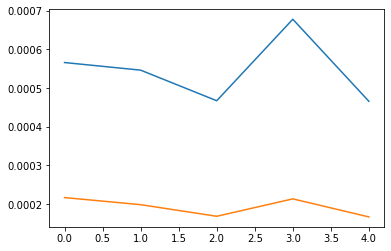

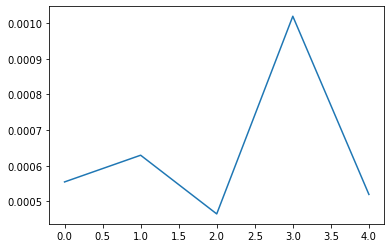

In [50]:
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
#plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [51]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 8s 8ms/step - loss: 4.6553e-04 - Sales_loss: 1.6654e-04 - Customers_loss: 1.7597e-04 - Sales_mse: 1.6654e-04 - Sales_rmspe: 0.0152 - Customers_mse: 1.7597e-04 - Customers_rmspe: 0.0176


[0.00046553072752431035,
 0.000166540194186382,
 0.00017597344412934035,
 0.000166540194186382,
 0.015213917940855026,
 0.00017597344412934035,
 0.017577359452843666]

In [52]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 8s 8ms/step - loss: 4.6553e-04 - Sales_loss: 1.6654e-04 - Customers_loss: 1.7597e-04 - Sales_mse: 1.6654e-04 - Sales_rmspe: 0.0152 - Customers_mse: 1.7597e-04 - Customers_rmspe: 0.0176


[0.00046553072752431035,
 0.000166540194186382,
 0.00017597344412934035,
 0.000166540194186382,
 0.015213917940855026,
 0.00017597344412934035,
 0.017577359452843666]

In [53]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [54]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 10s 8ms/step


In [56]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.13821594668728304

In [57]:
y_pred_test[:10]

array([3730.7488, 5724.1514, 8094.047 , 5143.2314, 5541.571 , 5012.5503,
       6793.315 , 6110.6167, 3679.8403, 5025.656 ], dtype=float32)

# Baseline

In [58]:
import pandas as pd
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')

In [59]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [60]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [61]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [62]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [63]:
sample_csv['Sales'] = df_test['Sales']

In [64]:
#sample_csv.to_csv(f'submision_baseline.csv', index=False) #Baseline is gwn gemiddelde per winkel --> sws hoger dan baseline halen

In [65]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [66]:

sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [141]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


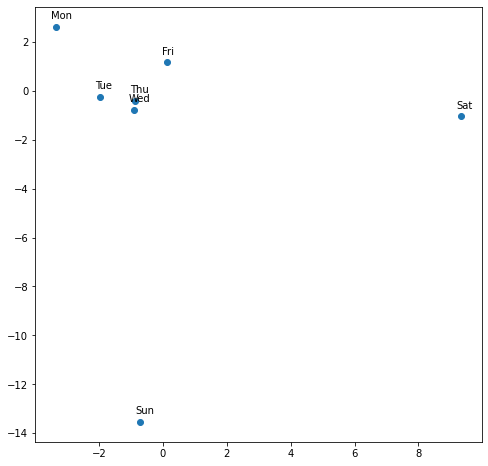

In [146]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

In [143]:
plot_embed('Month_Embed', list(range(12)))

ValueError: No such layer: Month_Embed. Existing layers are: ['Store_input', 'DayOfWeek_input', 'Store_Embed', 'DayOfWeek_Embed', 'Store_flat', 'DayOfWeek_flat', 'BeforeStateHoliday_bool_input', 'Max_TemperatureC_input', 'All_Concatenate', 'dense_11', 'activation_10', 'dense_12', 'activation_11', 'Sales', 'Customers'].

In [144]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [145]:
day_of_week_embedding.shape

NameError: name 'day_of_week_embedding' is not defined

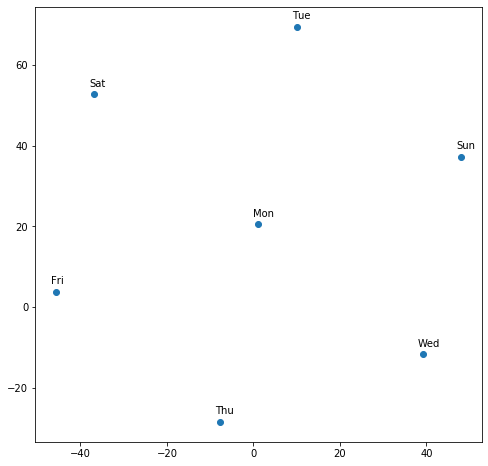

In [58]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [93]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'State',
 'Week',
 'Events',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_fw',
 'StateHoliday_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

## Store embeddings

In [94]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [95]:
submodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [52]:
submodel.save('embeddings_model.hdf5')